In [1]:
%cd /rds/general/user/ad2821/home/Delta_PINNs

/rds/general/user/ad2821/home/Delta_PINNs


In [17]:
from jaxpinns.ntk import compute_ntk, sum_and_contract
from jax.flatten_util import ravel_pytree
from jax import jacobian

In [2]:
from jaxpinns.base import PINN
%load_ext autoreload
%autoreload 2





import jax
from jax import custom_jvp
import pickle
from jax import random
from jax.example_libraries import optimizers
from scipy.linalg import eigh

import pyvista as pv
import os






from jax import random, grad, jit, vmap, lax
from jax.tree_util import Partial as partial
from jax.ops import segment_sum



import numpy as np


from Mesh import Mesh


import jax.numpy as jnp
from jax import random, grad, vmap, jvp


from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers


from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam
from jaxpinns.loggers import logger

import matplotlib.pyplot as plt

from torch.utils import data

from scipy.sparse.linalg import spsolve


np.random.seed(1234)
rng_key = random.PRNGKey(0)

import time
import meshio
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

import igl

2025-06-17 09:17:49.670622: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.7 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
print(jax.devices())
print(jax.lib.xla_bridge.get_backend().platform)

[cuda(id=0)]
gpu


2025-06-17 09:18:20.176 (  12.740s) [    147D31FD8140]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
/rds/general/user/ad2821/home/miniforge3/envs/thesis_New/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


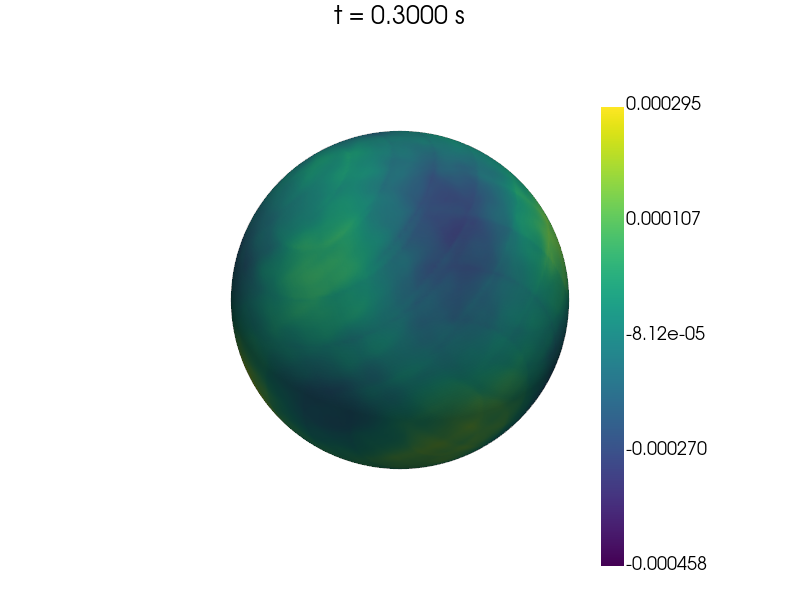

In [4]:

filename = os.path.expanduser(
    "data/SOL_sphere_gamma_10_rs_0.001_dt_1e3_T_0.3_82k.npy"
)
data_m = np.load(filename, allow_pickle=True).item()
coords       = data_m["mesh_coordinates"]

t_star       = data_m["t_star"]
phi_e        = data_m["phi_e"]
Qs           = data_m["Qs"]


mvtu = meshio.read("data/MESH_sphere_gamma_10_rs_0.001_dt_1e3_T_0.3_82k.vtu")

verts = mvtu.points
connectivity = mvtu.cells_dict['VTK_LAGRANGE_TRIANGLE']
tris = connectivity

n_faces = tris.shape[0]
faces   = np.hstack([np.full((n_faces, 1), 3, dtype=np.int64), tris]).reshape(-1)
pv_mesh = pv.PolyData(coords, faces)

k = -1
pv_mesh["phi"] = phi_e[100]


p = pv.Plotter(window_size=(800, 600))
p.add_mesh(pv_mesh, scalars="phi", cmap="viridis", show_edges=False, show_scalar_bar=False)
p.hide_axes()
p.add_scalar_bar(title="phi", vertical=True, position_x=0.75, position_y=0.05, height=0.80, width=0.08)
p.add_text(f"t = {t_star[k]:.4f} s", position="upper_edge", font_size=10)
p.show()

In [9]:
verts=coords
connectivity=tris
m = Mesh(verts = verts, connectivity = connectivity)

In [10]:

n_eigs = 120

folder = "Eig"
eigvals  = np.load(f"{folder}/Sphere_eigvals_82k_50.npy")
eigvecs = np.load(f"{folder}/Sphere_eigvecs_82k_50.npy")















In [11]:
Kigl = igl.cotmatrix(m.verts, m.connectivity.astype(int))
Migl = igl.massmatrix(m.verts, m.connectivity.astype(int))
print('Mx calculated')
Kigl = csr_matrix(Kigl)
Migl = csr_matrix(Migl)
print('converterd to csr')
numlap = Kigl.tolil()

Mx calculated
converterd to csr


In [12]:
class DampedWavePINN(PINN):
    def __init__(self,
                 eigenfuncs,
                 connectivity,
                 mesh_operator,
                 gamma_s,
                 r_s,
                 batch_size=64):
        super().__init__()
        self.num_loss_terms = 3
        self.eigenfuncs   = jnp.array(eigenfuncs)
        self.connectivity = jnp.array(connectivity)
        self.verts        = jnp.array(mesh_operator.verts)
        self.normals      = jnp.array(mesh_operator.normals)
        self.mesh_operator= mesh_operator
        self.gamma_s      = gamma_s
        self.r_s          = r_s
        self.batch_size   = batch_size

    def net_r(self, params, x):
        return grad(self.net_u, 1)(params, x)

    def net_u(self, params, x):
        return self.net_apply(params, x[None,...])[0,0]

    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, batch):

        (ic_in, pde_in, _), (_, pde_tgt, _), (data_in, _) = batch
        Vb_ic, _   = ic_in
        X_ic       = jnp.concatenate([Vb_ic, jnp.zeros((Vb_ic.shape[0],1))], axis=1)
        J_ic       = vmap(grad(self.net_u), in_axes=(None,0))(params, X_ic)
        du_ic, _   = ravel_pytree(J_ic)
        tr_ic      = jnp.dot(du_ic, du_ic)


        V_flat, vals, segments, t_flat, V_coll, t_coll = pde_in
        Q_res = pde_tgt[0]

        bs, D = V_coll.shape[0], V_flat.shape[1] + 1
        max_deg = vals.shape[0] // bs


        X_flat_grouped = jnp.concatenate([V_flat, t_flat[:,None]], axis=1)
        X_flat_grouped = X_flat_grouped.reshape(bs, max_deg, D)
        vals_grouped   = vals.reshape(bs, max_deg)
        X_coll         = jnp.concatenate([V_coll, t_coll[:,None]], axis=1)

        def R_single(theta, x_flat_i, vals_i, x_coll_i, q_i):

            phi_flat = vmap(lambda x: self.net_u(theta, x))(x_flat_i)
            lap_res  = jnp.sum(vals_i * phi_flat)


            v_pt, t_pt = x_coll_i[:-1], x_coll_i[-1]
            phi_t  = grad(lambda tau: self.net_u(theta, jnp.concatenate([v_pt, jnp.array([tau])])))(t_pt)
            phi_tt = grad(lambda tau: grad(lambda sigma: self.net_u(theta, jnp.concatenate([v_pt, jnp.array([sigma])])))(tau))(t_pt)
            u_val  = self.net_u(theta, x_coll_i)
            rhs    = (1.0/self.gamma_s**2)*phi_tt + (2.0/self.gamma_s)*phi_t + u_val - q_i

            raw = lap_res - rhs/(self.r_s**2)
            return raw * (self.r_s**2)

        def single_trace(theta, x_flat_i, vals_i, x_coll_i, q_i):
            g_i, _ = ravel_pytree(grad(R_single, argnums=0)(theta, x_flat_i, vals_i, x_coll_i, q_i))
            return jnp.dot(g_i, g_i)


        tr_r_per_sample = vmap(single_trace, in_axes=(None, 0, 0, 0, 0))(
            params,
            X_flat_grouped,
            vals_grouped,
            X_coll,
            Q_res
        )
        tr_r = jnp.sum(tr_r_per_sample)


        Vd, td  = data_in
        X_d     = jnp.concatenate([Vd, td[:,None]], axis=1)
        J_d     = vmap(grad(self.net_u), in_axes=(None,0))(params, X_d)
        du_d, _ = ravel_pytree(J_d)
        tr_d    = jnp.dot(du_d, du_d)


        T = tr_ic + tr_r + tr_d
        return (T/tr_ic, T/tr_r, T/tr_d)


    @partial(jit, static_argnums=(0,))
    def compute_NTK_spectrum(self, params, batch):

      (ic_in, pde_in, _), (_, _, _), (data_in, _) = batch
      Vb_ic, _          = ic_in
      V_flat, *_rest    = pde_in
      _, _, _, t_flat, V_coll, t_coll = pde_in
      Vb_data, t_data   = data_in


      X_ic   = jnp.concatenate([Vb_ic, jnp.zeros((Vb_ic.shape[0],1))], axis=1)
      X_pde  = jnp.concatenate([V_coll, t_coll[:,None]], axis=1)
      X_data = jnp.concatenate([Vb_data, t_data[:,None]], axis=1)


      def u_fn(p, X):
          return vmap(lambda x: self.net_u(p, x))(X)[:,None]


      K_ii = compute_ntk(params, u_fn,     u_fn,     (X_ic,),   (X_ic,))
      K_ip = compute_ntk(params, u_fn,     u_fn,     (X_ic,),   (X_pde,))
      K_id = compute_ntk(params, u_fn,     u_fn,     (X_ic,),   (X_data,))
      K_pp = compute_ntk(params, u_fn,     u_fn,     (X_pde,),  (X_pde,))
      K_pd = compute_ntk(params, u_fn,     u_fn,     (X_pde,),  (X_data,))
      K_dd = compute_ntk(params, u_fn,     u_fn,     (X_data,), (X_data,))


      top    = jnp.concatenate([K_ii, K_ip, K_id], axis=1)
      middle = jnp.concatenate([K_ip.T, K_pp, K_pd], axis=1)
      bottom = jnp.concatenate([K_id.T, K_pd.T, K_dd], axis=1)
      K = jnp.concatenate([top, middle, bottom], axis=0)


      eigvals, eigvecs = jnp.linalg.eigh(K)
      idx = jnp.argsort(eigvals)[::-1]
      return eigvals[idx], eigvecs[:,idx]


    @partial(jit, static_argnums=(0,))
    def loss_b_fe(self, params, batch):
        """
        batch = ((ic_in, pde_in, bdry_in), (ic_tgt, pde_tgt, bdry_tgt))
        We only care about bdry_in = (batch_elems, t_bdry).
        """

        (ic_in, pde_in, bdry_in), (ic_tgt, pde_tgt, bdry_tgt), _ = batch
        batch_elems, t_bdry = bdry_in

        def single_flux(e_idx, t_val):

            tri_nodes = self.connectivity[e_idx]
            i0, i1, i2 = tri_nodes[0], tri_nodes[1], tri_nodes[2]

            v_i = self.eigenfuncs[i0]
            v_j = self.eigenfuncs[i1]
            v_k = self.eigenfuncs[i2]

            x_i = jnp.concatenate([v_i, jnp.array([t_val])])
            x_j = jnp.concatenate([v_j, jnp.array([t_val])])
            x_k = jnp.concatenate([v_k, jnp.array([t_val])])

            u_i = self.net_u(params, x_i)
            u_j = self.net_u(params, x_j)
            u_k = self.net_u(params, x_k)

            coords = self.verts[tri_nodes]

            e1 = (coords[1] - coords[0]) / jnp.linalg.norm(coords[1] - coords[0])
            temp = coords[2] - coords[0]
            proj = jnp.dot(temp, e1) * e1
            e2 = temp - proj
            e2 = e2 / jnp.linalg.norm(e2)
            e3 = jnp.cross(e1, e2)

            x21 = jnp.dot(coords[1] - coords[0], e1)
            x13 = jnp.dot(coords[0] - coords[2], e1)
            x32 = jnp.dot(coords[2] - coords[1], e1)
            y23 = jnp.dot(coords[1] - coords[2], e2)
            y31 = jnp.dot(coords[2] - coords[0], e2)
            y12 = jnp.dot(coords[0] - coords[1], e2)

            Bmat = jnp.stack([
                jnp.array([y23, y31, y12]),
                jnp.array([x32, x13, x21])
            ], axis=0)
            Jdet = x13 * y23 - y31 * x32

            uv      = jnp.array([u_i, u_j, u_k])
            grad2D  = (Bmat @ uv) / Jdet
            grad_loc = jnp.array([grad2D[0], grad2D[1], 0.0])
            R       = jnp.stack([e1, e2, e3], axis=1)
            grad3D  = R @ grad_loc
            gx, gy, gz = grad3D[0], grad3D[1], grad3D[2]


            n_x, n_y, n_z = self.normals[e_idx]

            return gx * n_x + gy * n_y + gz * n_z

        fluxes = vmap(single_flux)(batch_elems, t_bdry)

        return jnp.mean(fluxes**2)


    @partial(jit, static_argnums=(0,))
    def loss_ic(self, params, batch):

        (ic_in, pde_in, bdry_in), (ic_tgt, pde_tgt, bdry_tgt), _ = batch


        V_b, _ = ic_in
        Y_b, Y_b_vel  = ic_tgt

        batch_size = V_b.shape[0]
        t0 = jnp.zeros((batch_size, 1))
        Xb = jnp.concatenate([V_b, t0], axis=1)
        u_pred = vmap(lambda x: self.net_u(params, x))(Xb)

        loss_phi0 = jnp.mean((Y_b - u_pred)**2)







        return loss_phi0

    @partial(jit, static_argnums=(0,))
    def loss_data(self, params, batch):

        (_, _, _), (_, _, _), (data_in, data_tgt) = batch

        V_b_data, t_b_data = data_in


        Y_b_data = data_tgt[0]

        t_arr = t_b_data.reshape((-1,1))
        Xb_data = jnp.concatenate([V_b_data, t_arr], axis=1)

        u_pred = vmap(lambda x: self.net_u(params, x))(Xb_data)

        mse = jnp.mean((Y_b_data - u_pred)**2)
        return mse

    @partial(jit, static_argnums=(0,))
    def loss_r(self, params, batch):


        (ic_in, pde_in, bdry_in), (ic_tgt, pde_tgt, bdry_tgt), _ = batch
        V_flat, vals, segments, t_flat, V_coll, t_coll = pde_in
        Q_res = pde_tgt[0]

        XT_flat = jnp.concatenate([V_flat, t_flat[:, None]], axis=1)
        phi_flat = vmap(lambda x: self.net_u(params, x))(XT_flat)
        lap_res = segment_sum(vals * phi_flat, segments, num_segments=self.batch_size)

        phi_t  = vmap(lambda v, t:
                      grad(lambda tt, vv: self.net_u(params,
                          jnp.concatenate([vv, jnp.array([tt])])), 0)(t, v)
                     )(V_coll, t_coll)
        phi_tt = vmap(lambda v, t:
                      grad(lambda tt:
                          grad(lambda ss, vv: self.net_u(params,
                            jnp.concatenate([vv, jnp.array([ss])])), 0)(tt, v)
                      , 0)(t)
                     )(V_coll, t_coll)

        uv_at_coll = vmap(lambda x: self.net_u(params, x))(
                          jnp.concatenate([V_coll, t_coll[:, None]], axis=1)
                       )
        rhs_raw = (1 / self.gamma_s**2) * phi_tt \
                  + (2 / self.gamma_s) * phi_t \
                  + uv_at_coll - Q_res

        raw = lap_res - rhs_raw / (self.r_s**2)
        res = raw * (self.r_s**2)
        return jnp.mean(res**2)


    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch, weights=(1.0,  1,1)):


        L_u = self.loss_ic(params, batch)
        L_r = self.loss_r(params, batch)

        L_d = self.loss_data(params, batch)
        return weights[0]*L_u + weights[1]*L_r  + weights[2]*L_d


    def predict(self, params, V, t):
        t_arr = jnp.ones((V.shape[0], 1)) * t
        X = jnp.concatenate([V, t_arr], axis=1)
        return vmap(lambda x: self.net_u(params, x))(X)


In [13]:


n_nodes = m.verts.shape[0]
N = n_nodes
rng_key, subkey = random.split(rng_key)
idx_train = random.choice(random.PRNGKey(30), n_nodes, (N,), replace = False)





Y_ic = phi_e
idx_c   = jnp.arange(n_nodes)
times   = t_star
Qvals   = Qs

n_eigs = 50
eigfuncs = eigvecs[:, :n_eigs]
V_ic = eigfuncs


In [14]:
phi_e_jax  = jnp.array(phi_e)[100:]
Qs_jax     = jnp.array(Qs)[100:]
times_jax  = jnp.array(t_star)[100:] - 0.1003344481605351

In [29]:



dt = times_jax[1] - times_jax[0]

phi0 = phi_e_jax[0]
phi1 = phi_e_jax[1]
phi_vel0 = (phi1 - phi0) / dt



n_eigs = 40
eigfuncs = eigvecs[:, :n_eigs]
V_ic = eigfuncs

L = numlap.tocsr()
N = L.shape[0]
degrees = np.diff(L.indptr)
max_deg = int(degrees.max())

neighbor_idx = np.zeros((N, max_deg), dtype=np.int32)
neighbor_wts = np.zeros((N, max_deg), dtype=np.float32)
degree_mask  = np.zeros((N, max_deg), dtype=bool)

for i in range(N):
    start, end = L.indptr[i], L.indptr[i+1]
    nbrs = L.indices[start:end]
    wts  = L.data[start:end]
    d    = len(nbrs)

    neighbor_idx[i, :d] = nbrs
    neighbor_wts[i, :d] = wts
    degree_mask[i, :d]  = True


neighbor_idx = jnp.array(neighbor_idx)
neighbor_wts = jnp.array(neighbor_wts)
degree_mask  = jnp.array(degree_mask)






class JAXLaplaceBatcher:
    def __init__(self,
                 eigenfuncs,
                 neighbor_idx,
                 neighbor_wts,
                 degree_mask,
                 normals,
                 times,
                 Qvals,
                 phi_e,
                 batch_size,
                 bdry_batch_size,
                 phi_vel0):
        self.eig    = jnp.array(eigenfuncs)
        self.nbr    = neighbor_idx
        self.wts    = neighbor_wts
        self.mask   = degree_mask
        self.norms  = jnp.array(normals)
        self.times  = jnp.array(times)
        self.Qvals  = jnp.array(Qvals)
        self.phi_e  = phi_e
        self.bs     = batch_size
        self.bbs    = bdry_batch_size

        self.phi_vel0 = jnp.array(phi_vel0)

    def __call__(self, key):

        k_ic, k_pde, k_bdry, k_data_nodes, k_data_times = random.split(key, 5)


        idx_ic = random.choice(k_ic, self.eig.shape[0], (self.bs,), replace=True)
        Vb_ic  = self.eig[idx_ic]
        Yb_ic  = self.phi_e[0, idx_ic]

        Yb_vel_ic = self.phi_vel0[idx_ic]


        k_x, k_t = random.split(k_pde)
        idx_x = random.choice(k_x, self.eig.shape[0], (self.bs,), replace=True)
        idx_t = random.choice(k_t, self.times.shape[0], (self.bs,), replace=True)



        nbrs = self.nbr[idx_x]; wts = self.wts[idx_x]; msk = self.mask[idx_x]
        segments   = jnp.broadcast_to(jnp.arange(self.bs)[:,None], nbrs.shape).reshape(-1)
        nodes_flat = nbrs.reshape(-1)
        vals_flat  = (wts * msk).reshape(-1)
        t_flat     = jnp.repeat(self.times[idx_t], nbrs.shape[1])
        V_coll = self.eig[idx_x]; t_coll = self.times[idx_t]
        Q_res  = self.Qvals[idx_t, idx_x]



        k_bd_idx, k_t_bd = random.split(k_bdry)
        bd_idx = random.choice(k_bd_idx, self.norms.shape[0], (self.bbs,), replace=False)
        t_bd   = random.choice(k_t_bd, self.times.shape[0],   (self.bbs,), replace=True)


        idx_nodes_data = random.choice(k_data_nodes,
                                       self.eig.shape[0],
                                       (self.bs,),
                                       replace=True)
        idx_times_data = random.choice(k_data_times,
                                       self.times.shape[0],
                                       (self.bs,),
                                       replace=True)
        Vb_data = self.eig[idx_nodes_data]
        t_b_data = self.times[idx_times_data]
        Yb_data = self.phi_e[idx_times_data, idx_nodes_data]


        ic_in   = (Vb_ic, None)
        ic_tgt  = (Yb_ic, Yb_vel_ic)

        pde_in  = (self.eig[nodes_flat], vals_flat, segments, t_flat, V_coll, t_coll)
        pde_tgt = (Q_res,)

        bd_in   = (bd_idx, self.times[t_bd])
        bd_tgt  = (jnp.zeros((self.bbs,)),)

        data_in  = (Vb_data, t_b_data)
        data_tgt = (Yb_data,)

        return (ic_in, pde_in, bd_in), (ic_tgt, pde_tgt, bd_tgt), (data_in, data_tgt)





model = DampedWavePINN(
    eigenfuncs    = eigfuncs,
    connectivity  = m.connectivity,
    mesh_operator = m,
    gamma_s       = 10,
    r_s           =  0.001,
    batch_size    = 30_00

)


init_key = random.PRNGKey(0)
layers   = [n_eigs + 1, 128, 128, 128, 1]
model.architecture(MLP, layers, init_key=init_key)


model.optimizer(adam, 1e-3, model.loss)
io_keys  = ['loss', 'loss_ic', 'loss_r', 'loss_d']
log_keys = io_keys
log_funs = [model.loss, model.loss_ic, model.loss_r, model.loss_data]
model.logger(logger, io_keys, log_keys, log_funs, io_step=50)
init_params = model.get_params(model.opt_state)





jax_batcher = JAXLaplaceBatcher(
    eigenfuncs     = eigfuncs,
    neighbor_idx   = neighbor_idx,
    neighbor_wts   = neighbor_wts,
    degree_mask    = degree_mask,
    normals        = m.normals,
    times          = times_jax,
    Qvals          = Qs_jax,
    phi_e          = phi_e_jax,
    batch_size     = 3000,
    bdry_batch_size= 300,
    phi_vel0 = phi_vel0
)


model.train_jax(
    dataset     = jax_batcher,
    nIter       = 10_000,
    ntk_weights = False,
    weights     = (1, 1,1)
)
print("done")


done


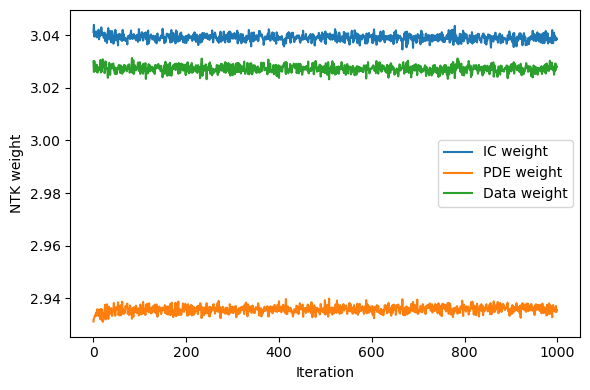

In [23]:
logs    = model.training_log
w_ic    = np.array(logs['w_ic'])
w_pde   = np.array(logs['w_pde'])
w_data  = np.array(logs['w_data'])

iters   = np.arange(len(w_ic))

plt.figure(figsize=(6,4))
plt.plot(iters, w_ic,   label='IC weight')
plt.plot(iters, w_pde,  label='PDE weight')
plt.plot(iters, w_data, label='Data weight')
plt.xlabel('Iteration')
plt.ylabel('NTK weight')
plt.legend()
plt.tight_layout()
plt.show()

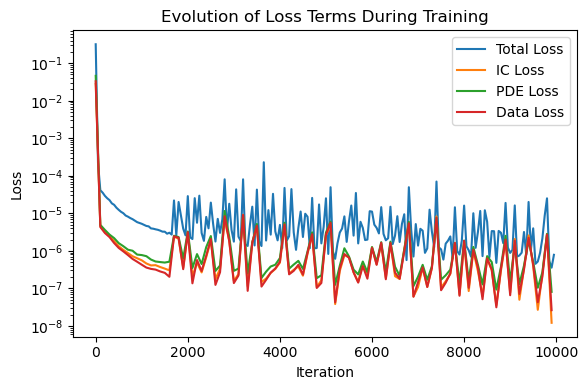

In [39]:

logs     = model.training_log
loss     = np.array(logs['loss'])
loss_ic  = np.array(logs['loss_ic'])
loss_r   = np.array(logs['loss_r'])
loss_data= np.array(logs['loss_d'])

iters = np.arange(len(loss))

plt.figure(figsize=(6,4))
plt.semilogy(iters[::50], loss[::50],      label='Total Loss')
plt.semilogy(iters[::100], loss_ic[::100],   label='IC Loss')
plt.semilogy(iters[::100], loss_r[::100],    label='PDE Loss')
plt.semilogy(iters[::100], loss_data[::100] , label='Data Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Evolution of Loss Terms During Training')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
print(f'Ltotal:{np.min(loss)} L_data:{np.min(loss_data)}, L_pde: {np.min(loss_r)}, Loss_ic:{np.min(loss_ic)}')

Ltotal:0.0006537389708682895 L_data:2.543770278862212e-07, L_pde: 0.0005991877405904233, Loss_ic:2.8890343628518167e-07


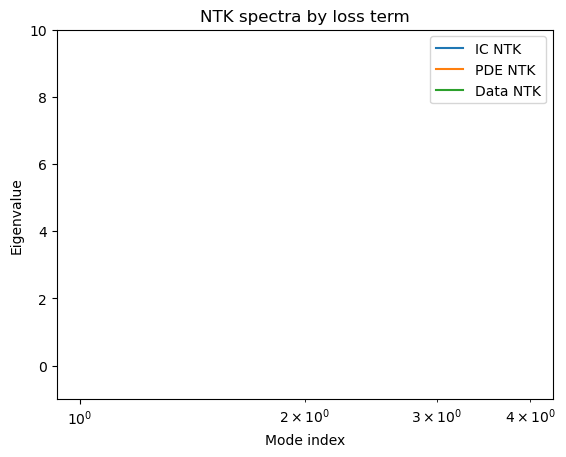

In [31]:
key   = random.PRNGKey(400)
batch = jax_batcher(key)


(ic_in,    pde_in, _), \
 (ic_tgt,  pde_tgt, _), \
 (data_in, data_tgt) = batch


Vb_ic, _      = ic_in
u_init_all, _ = ic_tgt
X_ic_full     = jnp.concatenate([Vb_ic, jnp.zeros((Vb_ic.shape[0],1))], axis=1)


_, _, _, _, V_coll, t_coll = pde_in
Q_all                      = pde_tgt[0]
X_pde_full                 = jnp.concatenate([V_coll, t_coll[:,None]], axis=1)


Vb_data, t_data = data_in
y_all           = data_tgt[0]
X_data_full     = jnp.concatenate([Vb_data, t_data[:,None]], axis=1)


M            = 1000
X_ic         = X_ic_full[:M]
u_init_slice = u_init_all[:M]

X_pde        = X_pde_full[:M]
Q_slice      = Q_all[:M]

X_data       = X_data_full[:M]
y_slice      = y_all[:M]


def f_ic(params, X):

    return vmap(lambda x, init_val: model.net_u(params, x) - init_val, in_axes=(0, 0))(
        X, u_init_slice
    )[:, None]


def residual_fn(params, x, q_val):
    pos = x[:-1]
    time = x[-1]

    u_time = grad(lambda t: model.net_u(params, jnp.concatenate([pos, jnp.array([t])])))(time)

    u_time2 = grad(lambda t: grad(lambda s: model.net_u(params, jnp.concatenate([pos, jnp.array([s])])))(t))(time)
    u_val = model.net_u(params, x)
    gs = model.gamma_s
    return (1.0 / gs**2) * u_time2 + (2.0 / gs) * u_time + u_val - q_val

def f_pde(params, X):

    return vmap(lambda x, q_val: residual_fn(params, x, q_val), in_axes=(0, 0))(X, Q_slice)[:, None]

def f_data(params, X):

    return vmap(lambda x, y_val: model.net_u(params, x) - y_val, in_axes=(0, 0))(
        X, y_slice
    )[:, None]

params = model.get_params(model.opt_state)


K_ic   = compute_ntk(f_ic,   f_ic,   (X_ic,),   (X_ic,),   params)
K_pde  = compute_ntk(f_pde,  f_pde,  (X_pde,),  (X_pde,),  params)
K_data = compute_ntk(f_data, f_data, (X_data,), (X_data,), params)

eigs_ic   = jnp.linalg.eigvalsh(K_ic)[::-1]
eigs_pde  = jnp.linalg.eigvalsh(K_pde)[::-1]
eigs_data = jnp.linalg.eigvalsh(K_data)[::-1]



plt.semilogx(eigs_ic[:5],   label='IC NTK')
plt.semilogx(eigs_pde[:5],  label='PDE NTK')
plt.semilogx(eigs_data[:5], label='Data NTK')
plt.ylim(-1, 10)
plt.xlabel('Mode index')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('NTK spectra by loss term')
plt.show()

/rds/general/user/ad2821/home/miniforge3/envs/thesis_New/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:36: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


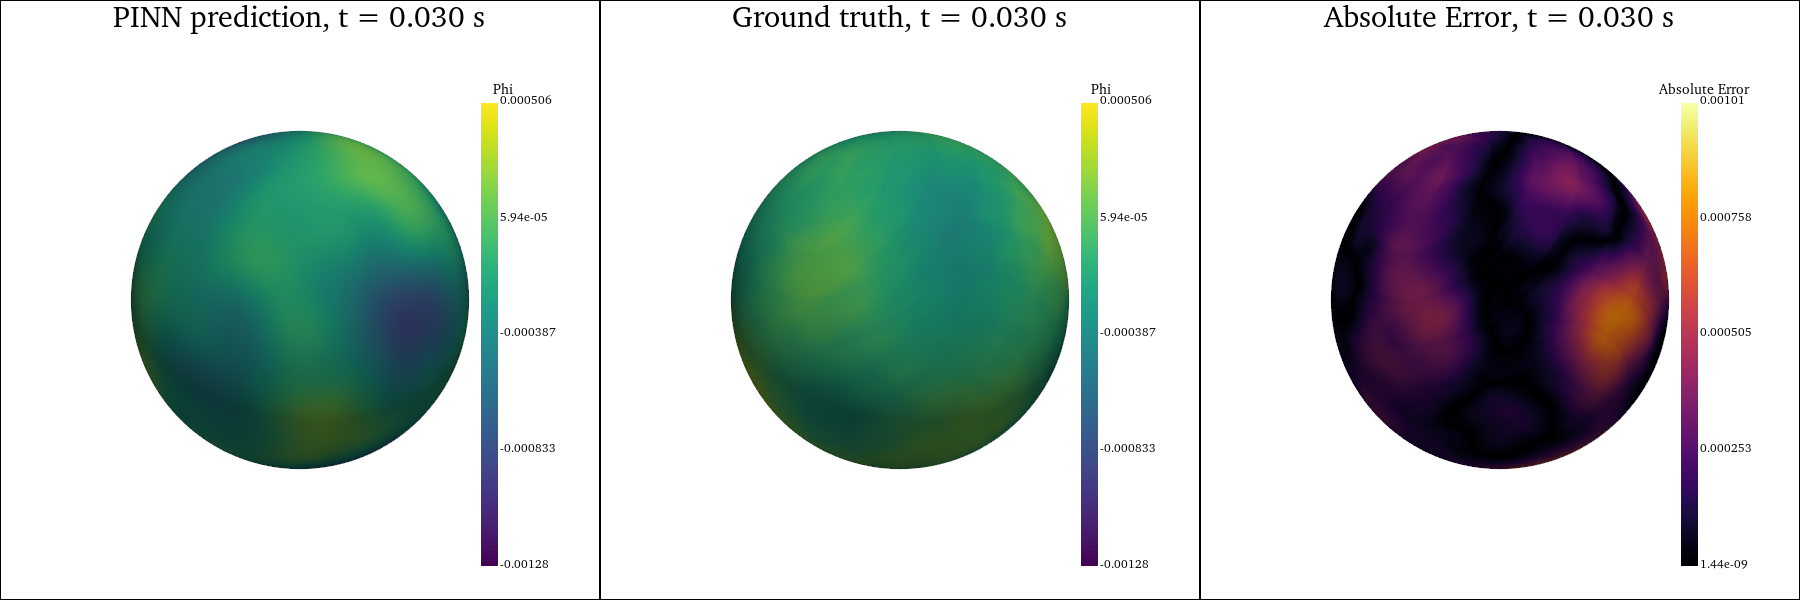

In [37]:



pv.global_theme.font.family = 'times'
t_query = 0.03010033
t_idx   = np.argmin(np.abs(times_jax - t_query))
t_actual = times_jax[t_idx]

phi_fem = phi_e_jax[t_idx, :]


opt_params = model.get_params(model.opt_state)
u_hat_norm = model.predict(opt_params, eigfuncs, t_actual)
phi_pred   = u_hat_norm

phi_error = np.abs(phi_pred - phi_fem)


tol = 1e-8
phi_rel_error = np.abs(phi_pred - phi_fem) / (np.abs(phi_fem) + tol)

n_faces = tris.shape[0]
faces_pv = np.hstack([
    np.full((n_faces, 1), 3, dtype=np.int64),
    tris
]).reshape(-1)
pv_mesh_p = pv.PolyData(coords, faces_pv)
pv_mesh_f = pv.PolyData(coords, faces_pv)
pv_mesh_e = pv.PolyData(coords, faces_pv)

pv_mesh_p["PINN"] = phi_pred
pv_mesh_f["FEM"] = phi_fem
pv_mesh_e["Abs_Error"]   = phi_error
pv_mesh_e["Rel_Error"]   = phi_rel_error

vmin = min(phi_pred.min(), phi_fem.min())
vmax = max(phi_pred.max(), phi_fem.max())

p = pv.Plotter(shape=(1, 3), window_size=(1800, 600))


p.subplot(0, 0)
p.add_mesh(
    pv_mesh_p,
    scalars="PINN",
    cmap="viridis",
    clim=(vmin, vmax),
    show_edges=False,
    show_scalar_bar=False
)
p.hide_axes()
p.add_scalar_bar(
    title="Phi",
    vertical=True,
    position_x=0.8,
    position_y=0.05,
    height=0.80,
    width=0.08,
    title_font_size=14,
    label_font_size=12
)
p.add_text(f"PINN prediction, t = {t_actual:.3f} s", position="upper_edge", font_size=12, color="black")


p.subplot(0, 1)
p.add_mesh(
    pv_mesh_f,
    scalars="FEM",
    cmap="viridis",
    clim=(vmin, vmax),
    show_edges=False,
    show_scalar_bar=False
)
p.hide_axes()
p.add_scalar_bar(
    title="Phi ",
    vertical=True,
    position_x=0.8,
    position_y=0.05,
    height=0.80,
    width=0.08,
    title_font_size=14,
    label_font_size=12
)
p.add_text(f"Ground truth, t = {t_actual:.3f} s", position="upper_edge", font_size=12, color="black")

p.subplot(0, 2)
p.add_mesh(
    pv_mesh_e,
    scalars="Abs_Error",
    cmap="inferno",
    show_edges=False,
    show_scalar_bar=False
)
p.hide_axes()
p.add_scalar_bar(
    title="Absolute Error",
    vertical=True,
    position_x=0.8,
    position_y=0.05,
    height=0.80,
    width=0.08,
    title_font_size=14,
    label_font_size=12
)
p.add_text(f"Absolute Error, t = {t_actual:.3f} s", position="upper_edge", font_size=12, color="black")




p.link_views()
p.show()

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def plot_wave_pinn_vs_fem_dual(
    t_query: float,
    t_star:  np.ndarray,
    phi_e:   np.ndarray,
    model,
    V_ic:    np.ndarray,
    normalize: bool = False
):

    idx      = np.argmin(np.abs(t_star - t_query))
    t_actual = float(t_star[idx])
    Y_true   = phi_e[idx]
    params   = model.get_params(model.opt_state)
    Y_pinn   = model.predict(params, V_ic, t_actual)

    if normalize:
        mu, sigma = phi_e[0].mean(), phi_e[0].std()
        Y_true = (Y_true - mu)/sigma
        Y_pinn = (Y_pinn - mu)/sigma
        label = "phi (normalized)"
    else:
        label = "phi (raw)"

    mse   = np.mean((Y_true - Y_pinn)**2)
    rho     = np.corrcoef(Y_true, Y_pinn)[0,1]
    mn, mx = min(Y_true.min(),Y_pinn.min()), max(Y_true.max(),Y_pinn.max())

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4), sharey=True)


    ax1.scatter(Y_true, Y_pinn, s=6, alpha=0.5)
    ax1.plot([mn,mx],[mn,mx],'k--',lw=1)
    ax1.set_aspect('equal')
    ax1.set_xlim(mn, mx)
    ax1.set_ylim(mn, mx)
    ax1.set_xlabel(label + ' Ground Truth')
    ax1.set_ylabel(label + ' Predicted')
    ax1.set_title(f"scatter t={t_actual:.3f}\nMSE={mse:.2e}, rho={rho:.2f}")


    idxs = np.arange(Y_true.size)
    ax2.scatter(idxs, Y_true, s=6, c='C0', label='FEM (true)')
    ax2.scatter(idxs, Y_pinn, s=6, c='C1', label='PINN pred')
    ax2.set_xlabel("node index")
    ax2.set_title("per‐node values")
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

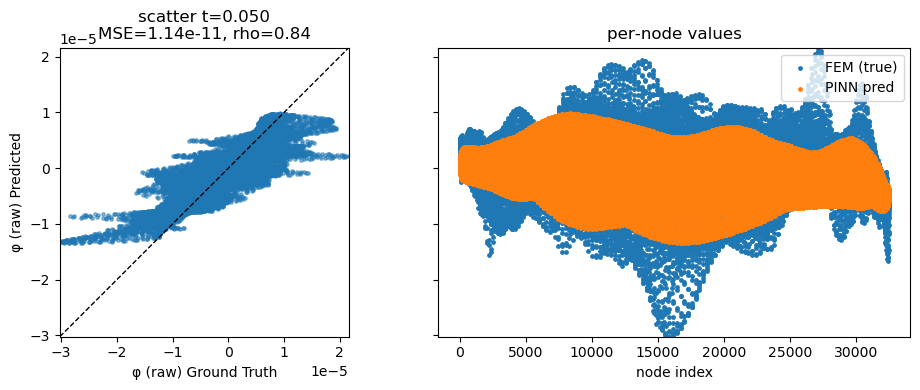

In [150]:
 plot_wave_pinn_vs_fem_dual(
    t_query   = 0.05005005,
    t_star    = times_jax,
    phi_e     = phi_e_jax,
    model     = model,
    V_ic      = eigfuncs,
    normalize = False
)

In [33]:
import numpy as onp

T, N = phi_e_jax.shape
params = model.get_params(model.opt_state)
sq_err = onp.zeros((T, N))
for t in range(T):
    preds = onp.array(model.predict(params, eigfuncs, times_jax[t]))
    true = onp.array(phi_e_jax[t])
    sq_err[t, :] = (preds - true)**2
pointwise_mse = sq_err.mean()
print(f"Overall MSE = {pointwise_mse:.3e}")
mse_per_time = sq_err.mean(axis=1)
mse_per_node = sq_err.mean(axis=0)


Overall MSE = 8.841e-08


In [34]:
mse_per_time[0]

8.901290641913763e-08

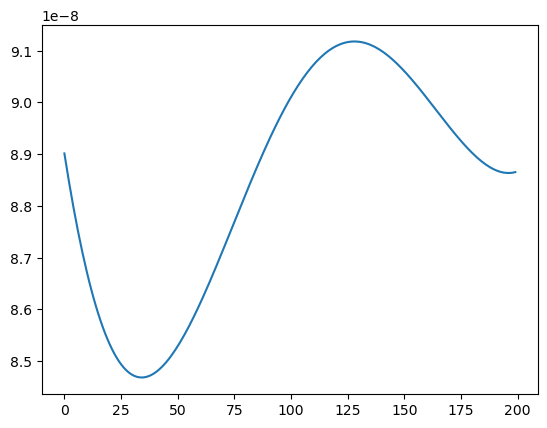

In [35]:
plt.plot(mse_per_time)

In [36]:
times_jax[30]

Array(0.03010033, dtype=float32)

In [184]:
np.savetxt('mse_x_t_brain_50k_lr6.csv' ,mse_per_time, delimiter = ',')

In [ ]:
    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, batch):

        (ic_in, pde_in, _), (_, pde_tgt, _), (data_in, _) = batch
        Vb_ic, _   = ic_in
        X_ic       = jnp.concatenate([Vb_ic, jnp.zeros((Vb_ic.shape[0],1))], axis=1)
        J_ic       = vmap(grad(self.net_u), in_axes=(None,0))(params, X_ic)
        du_ic, _   = ravel_pytree(J_ic)
        tr_ic      = jnp.dot(du_ic, du_ic)



        _, _, _, _, V_coll, t_coll = pde_in
        Q_res = pde_tgt[0]

        X_r = jnp.concatenate([V_coll, t_coll.reshape(-1,1)], axis=1)

        def R_pt(params, x, q_pt):
            v_pt = x[:-1]
            t_pt = x[-1]

            phi_t  = grad(lambda tau: self.net_u(params, jnp.concatenate([v_pt, jnp.array([tau])])), 0)(t_pt)
            phi_tt = grad(lambda tau: grad(lambda sigma: self.net_u(params, jnp.concatenate([v_pt, jnp.array([sigma])])), 0)(tau), 0)(t_pt)

            u_val  = self.net_u(params, x)
            return (1.0 / self.gamma_s**2) * phi_tt \
                 + (2.0 / self.gamma_s)     * phi_t  \
                 + u_val \
                 - q_pt

        J_r   = vmap(lambda x, q: grad(R_pt, 1)(params, x, q), in_axes=(0, 0))(X_r, Q_res)
        dr, _ = ravel_pytree(J_r)
        tr_r  = jnp.dot(dr, dr)


        Vd, td   = data_in
        X_d      = jnp.concatenate([Vd, td.reshape(-1,1)], axis=1)
        J_d      = vmap(grad(self.net_u), in_axes=(None,0))(params, X_d)
        du_d, _  = ravel_pytree(J_d)
        tr_d     = jnp.dot(du_d, du_d)


        T = tr_ic + tr_r + tr_d
        return (T/tr_ic, T/tr_r, T/tr_d)


In [38]:
n_eigs_list = [10, 20, 40, 50]
lrs         = [1e-3, 1e-4, 1e-5, 1e-6]
nIters      = [1000,  1000, 5000, 20_000]

for lr, nIter in zip(lrs, nIters):
    for n_eigs in n_eigs_list:
        eigfuncs = eigvecs[:, :n_eigs]

        model = DampedWavePINN(
            eigenfuncs    = eigfuncs,
            connectivity  = m.connectivity,
            mesh_operator = m,
            gamma_s       = 116.0,
            r_s           = 30.0,
            batch_size    = 3_000
        )
        init_key = random.PRNGKey(0)
        layers   = [n_eigs + 1, 128, 128, 128, 1]
        model.architecture(MLP, layers, init_key=init_key)
        model.optimizer(adam, lr, model.loss)


        model.logger(
            logger,
            ['loss','loss_ic','loss_r','loss_d'],
            ['loss','loss_ic','loss_r','loss_data'],
            [model.loss, model.loss_ic, model.loss_r, model.loss_data],
            io_step=500
        )

        jax_batcher = JAXLaplaceBatcher(
            eigenfuncs      = eigfuncs,
            neighbor_idx    = neighbor_idx,
            neighbor_wts    = neighbor_wts,
            degree_mask     = degree_mask,
            normals         = m.normals,
            times           = times_jax,
            Qvals           = Qs_jax,
            phi_e           = phi_e_jax,
            batch_size      = 3_000,
            bdry_batch_size = 300,
            phi_vel0        = phi_vel0
        )

        model.train_jax(
            dataset     = jax_batcher,
            nIter       = nIter,
            ntk_weights = False,
            weights     = (1, 1.0, 1)
        )

        params = model.get_params(model.opt_state)
        T, N = phi_e_jax.shape
        sq_err = np.zeros((T, N))
        for t in range(T):
            preds      = np.array(model.predict(params, eigfuncs, times_jax[t]))
            true_vals  = np.array(phi_e_jax[t])
            sq_err[t,:] = (preds - true_vals)**2

        overall_mse  = sq_err.mean()
        mse_at_t0    = sq_err.mean(axis=1)[0]

        print(
            f"n_eigs={n_eigs}, lr={lr}, nIter={nIter} -> "
            f"overall_mse={overall_mse:.3e}, mse_per_time[0]={mse_at_t0:.3e}"
        )

n_eigs=10, lr=0.001, nIter=1000 -> overall_mse=5.527e-07, mse_per_time[0]=4.458e-07
n_eigs=20, lr=0.001, nIter=1000 -> overall_mse=7.484e-08, mse_per_time[0]=7.484e-08
n_eigs=40, lr=0.001, nIter=1000 -> overall_mse=7.436e-08, mse_per_time[0]=7.109e-08
n_eigs=50, lr=0.001, nIter=1000 -> overall_mse=1.027e-07, mse_per_time[0]=9.656e-08
n_eigs=10, lr=0.0001, nIter=1000 -> overall_mse=2.229e-07, mse_per_time[0]=1.773e-07
n_eigs=20, lr=0.0001, nIter=1000 -> overall_mse=9.068e-07, mse_per_time[0]=8.464e-07
n_eigs=40, lr=0.0001, nIter=1000 -> overall_mse=7.486e-07, mse_per_time[0]=7.661e-07
n_eigs=50, lr=0.0001, nIter=1000 -> overall_mse=1.120e-06, mse_per_time[0]=1.163e-06
n_eigs=10, lr=1e-05, nIter=5000 -> overall_mse=2.018e-07, mse_per_time[0]=1.678e-07
n_eigs=20, lr=1e-05, nIter=5000 -> overall_mse=9.239e-07, mse_per_time[0]=8.753e-07
n_eigs=40, lr=1e-05, nIter=5000 -> overall_mse=8.741e-07, mse_per_time[0]=8.924e-07
n_eigs=50, lr=1e-05, nIter=5000 -> overall_mse=1.541e-06, mse_per_time[0